# Counting nuclei according to expression in multiple channels
A common bio-image analysis task is counting cells according to their signal expression in multiple channels. In this example we take a two-channel image of nuclei which express Cy3 and eGFP. Visually, we can easily see that some nuclei expressing Cy3 also express eGFP, others don't. This notebook demonstrates how to count these groups of nuclei.

In [1]:
import pyclesperanto_prototype as cle
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

cle.get_device()

<Apple M1 Max on Platform: Apple (2 refs)>

We're using a dataset published by [Heriche et al.](https://doi.org/10.1091/mbc.E13-04-0221) licensed [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) available in the [Image Data Resource](https://idr.openmicroscopy.org/webclient/img_detail/179719/).

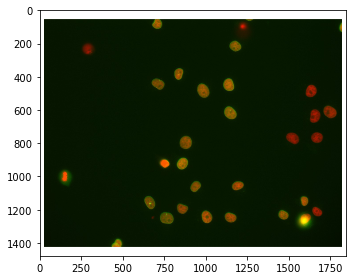

In [2]:
# load file
raw_image = imread('plate1_1_013 [Well 5, Field 1 (Spot 5)].png')

# visualize
imshow(raw_image)

First, we need to split channels ([read more](https://github.com/BiAPoL/Bio-image_Analysis_with_Python/blob/a62070dee408814cee4258758f5187f135774519/image_processing/03_multi_channel_image_data.ipynb)). After that, we can actually see that not all cells marked with Cy3 (channel 0) are also marked with eGFP (channel 1):

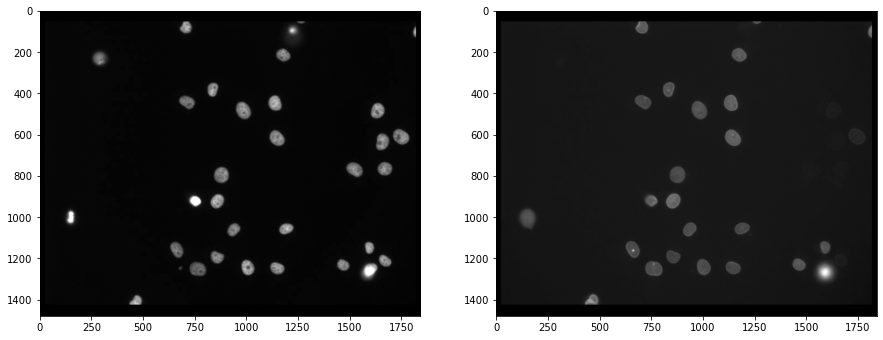

In [3]:
# extract channels
channel_0 = raw_image[...,0]
channel_1 = raw_image[...,1]

# visualize
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(channel_0, cmap='gray')
axs[1].imshow(channel_1, cmap='gray')

## Segmenting nuclei
As the staining marks the whole nucleus in both cases, it is reasonable to segmentn nuclei in both images and then process the segmented images further. We use [Voronoi-Otsu-Labeling](https://github.com/clEsperanto/pyclesperanto_prototype/blob/f9c9b73c1f9f194fdabdab8bd8507eb73c3ef8c9/demo/segmentation/voronoi_otsu_labeling.ipynb) for the segmentation because it is a quick and straightforward approach.

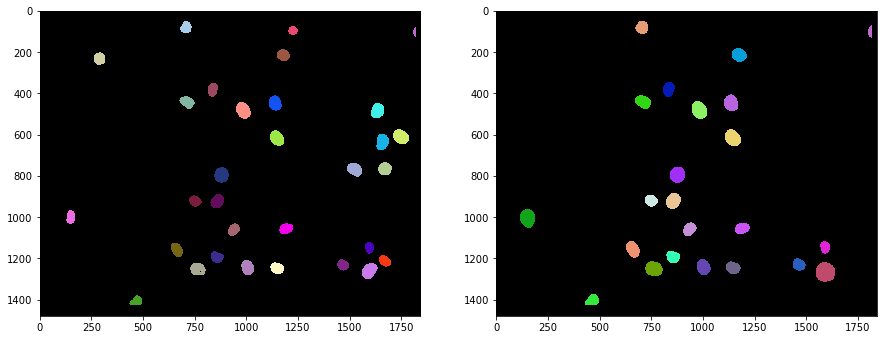

In [4]:
# segmentation
nuclei_cy3 = cle.voronoi_otsu_labeling(channel_0, spot_sigma=20)
nuclei_egfp = cle.voronoi_otsu_labeling(channel_1, spot_sigma=20)

# visualize
fig, axs = plt.subplots(1, 2, figsize=(15,15))
cle.imshow(nuclei_cy3, plot=axs[0], labels=True)
cle.imshow(nuclei_egfp, plot=axs[1], labels=True)

The above shown label images have inside nuclei pixel intensity values that correspond to the number of the nucleus. In nucleus 1, all pixels have intensity 1. In nucleus 2, all pixels have intensity 2 and so on. Hence, from these label images, we can already determine the number of nuclei in both channels, by measuring the maximum intensity in the label images:

In [5]:
# determine maximum in both label images
number_of_nuclei_cy3 = nuclei_cy3.max()
number_of_nuclei_egfp = nuclei_egfp.max()

# print out result
print("Nuclei Cy3 positive:", number_of_nuclei_cy3)
print("Nuclei eGFP positive:", number_of_nuclei_egfp)

Nuclei Cy3 positive: 31.0
Nuclei eGFP positive: 23.0


Technically, we haven't checked yet if all eGFP positive nuclei are also Cy3 positive. We can do this by determining how many eGFP positive nuclei are close by each individual Cy3 positive nucleus. Therefore, we need to set a maximum distance threshold allowing us to specify how far away centroids of nuclei are allowed to be.

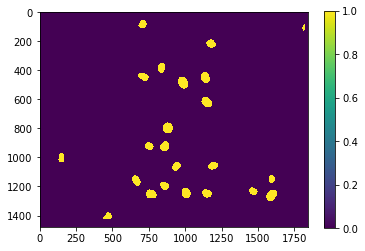

In [6]:
maximum_distance = 15 # pixels

# draw a parametric map of cell counts
count_map = cle.proximal_other_labels_count_map(nuclei_cy3, nuclei_egfp)
cle.imshow(count_map, colorbar=True)

The `count_map` is a parametric image. We can identify all the nuclei where the count value >= 1. These are all the Cy3-positive nuclei which have at least one eGFP-positive nucleus with a centroid distance <= 15 pixels. 

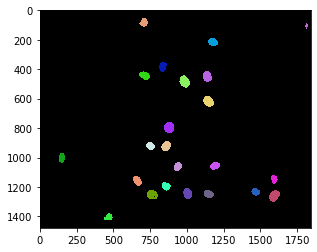

In [7]:
double_positive_nuclei = cle.exclude_labels_with_map_values_out_of_range(
    count_map, 
    nuclei_cy3, 
    minimum_value_range=1)

cle.imshow(double_positive_nuclei, labels=True)

And we can also count those similar to shown above:

In [8]:
number_of_double_positives = double_positive_nuclei.max()
print("Number of Cy3 positives that also express eGFP", number_of_double_positives)

Number of Cy3 positives that also express eGFP 23.0


## Visualization
We can also use the outlines around cells which are double positive and visualize those on the original images of both channels.

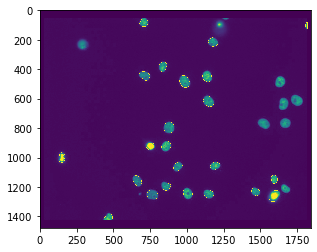

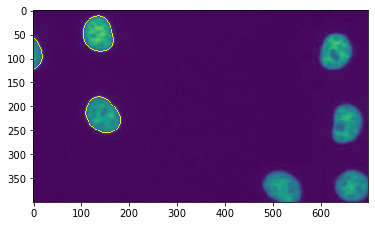

In [9]:
# determine outlines
outlines = cle.detect_label_edges(double_positive_nuclei)

# add outlines to original images. As outlines have value 1, 
# we need to multiply them to make them properly visible:
channel_0_with_outlines = cle.maximum_images(channel_0, outlines * channel_0.max())

# visualize result
cle.imshow(channel_0_with_outlines)

# let's zoom in
cle.imshow(channel_0_with_outlines.get()[400:800, 1000:1700])

For interactive visualization, we can also use [napari](https://napari.org):

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


/Users/haase/opt/anaconda3/envs/bio_39/lib/python3.9/site-packages/napari/plugins/_plugin_manager.py:494: UserWarning: Plugin 'napari-accelerated-pixel-and-object-classification' provided a non-callable type to `napari_experimental_provide_function`: <class 'magicgui._magicgui.MagicFactory'>. Function widget ignored.
  warn(message=warn_message)


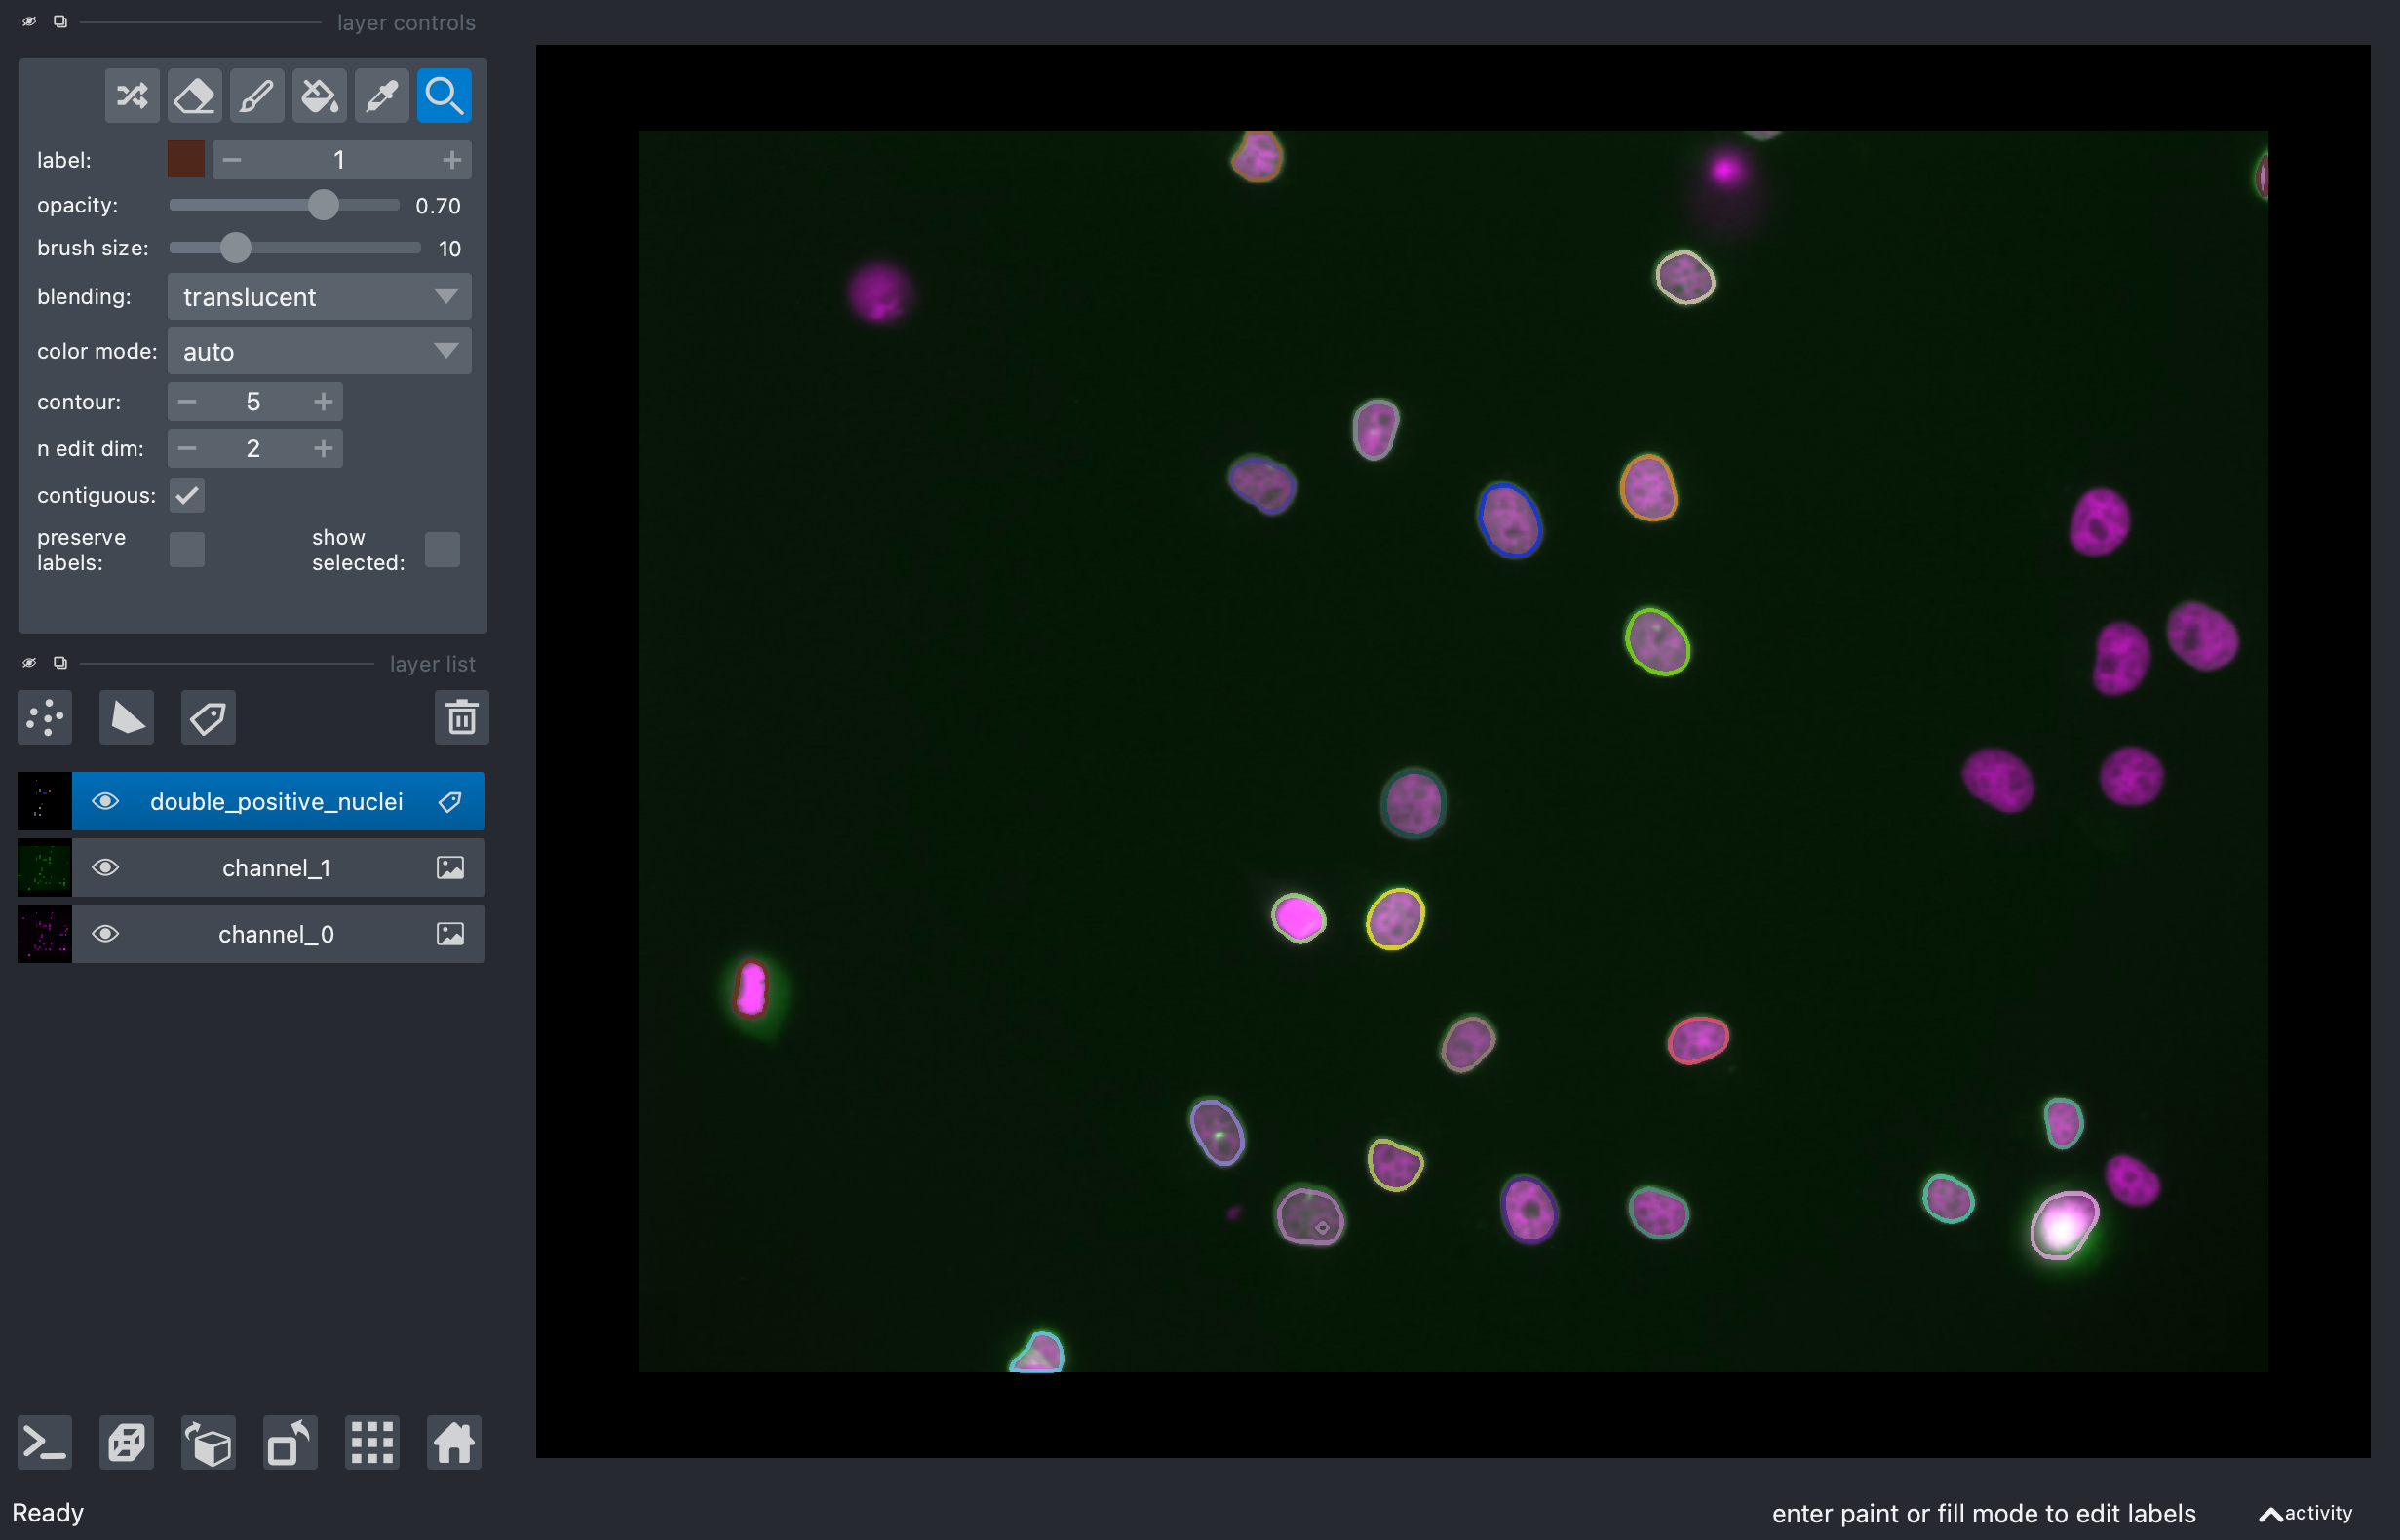

In [10]:
# startup a viewer
import napari
viewer = napari.Viewer()

# add raw images in color to the viewer
viewer.add_image(channel_0, colormap='magenta')
viewer.add_image(channel_1, colormap='green', blending='additive')

# add labels and configure it so that we see the contours as thick lines
labels_layer = viewer.add_labels(double_positive_nuclei)
labels_layer.contour=5

# make a screenshot of the viewer
napari.utils.nbscreenshot(viewer)

## References

Some of the functions we used might be uncommon. Hence, we can add their documentation for reference.

In [11]:
print(cle.voronoi_otsu_labeling.__doc__)

Labels objects directly from grey-value images.

    The two sigma parameters allow tuning the segmentation result. Under the hood,
    this filter applies two Gaussian blurs, spot detection, Otsu-thresholding [2] and Voronoi-labeling [3]. The
    thresholded binary image is flooded using the Voronoi tesselation approach starting from the found local maxima.
    
    Parameters
    ----------
    source : Image
        Input grey-value image
    label_image_destination : Image, optional
        Output image
    spot_sigma : float
        controls how close detected cells can be
    outline_sigma : float
        controls how precise segmented objects are outlined.
    
    Returns
    -------
    label_image_destination
    
    Examples
    --------
    >>> import pyclesperanto_prototype as cle
    >>> cle.voronoi_otsu_labeling(source, label_image_destination, 10, 2)
    
    References
    ----------
    .. [1] https://clij.github.io/clij2-docs/reference_voronoiOtsuLabeling
    .. [2]

In [12]:
print(cle.proximal_other_labels_count_map.__doc__)


    Count number of labels within a given radius in an other label image and returns the result as parametric map.

    Parameters
    ----------
    label_image: Image
    other_label_image: Image
    count_map: Image, optional
        parametric image where the values will be written in.
    maximum_distance: Number, optional
        maximum distance in pixels

    Returns
    -------
    count_map

    


In [13]:
print(cle.exclude_labels_with_map_values_out_of_range.__doc__)

This operation removes labels from a labelmap and renumbers the
    remaining labels.

    Parameters
    ----------
    values_map : Image
    label_map_input : Image
    label_map_destination : Image
    minimum_value_range : Number
    maximum_value_range : Number

    Returns
    -------
    label_map_destination

    References
    ----------
    .. [1] https://clij.github.io/clij2-docs/reference_excludeLabelsWithValuesWithinRange
    


In [14]:
print(cle.detect_label_edges.__doc__)

Takes a labelmap and returns an image where all pixels on label edges 
    are set to 1 and all other pixels to 0. 
    
    Parameters
    ----------
    label_map : Image
    edge_image_destination : Image
    
    Returns
    -------
    edge_image_destination
    
    Examples
    --------
    >>> import pyclesperanto_prototype as cle
    >>> cle.detect_label_edges(label_map, edge_image_destination)
    
    References
    ----------
    .. [1] https://clij.github.io/clij2-docs/reference_detectLabelEdges
    


In [15]:
print(cle.maximum_images.__doc__)

Computes the maximum of a pair of pixel values x, y from two given 
    images X and Y. 
    
    <pre>f(x, y) = max(x, y)</pre> 
    
    Parameters
    ----------
    source1 : Image
    source2 : Image
    destination : Image
    
    Returns
    -------
    destination
    
    Examples
    --------
    >>> import pyclesperanto_prototype as cle
    >>> cle.maximum_images(source1, source2, destination)
    
    References
    ----------
    .. [1] https://clij.github.io/clij2-docs/reference_maximumImages
    


In [16]:
print(napari.Viewer.__doc__)

Napari ndarray viewer.

    Parameters
    ----------
    title : string, optional
        The title of the viewer window. by default 'napari'.
    ndisplay : {2, 3}, optional
        Number of displayed dimensions. by default 2.
    order : tuple of int, optional
        Order in which dimensions are displayed where the last two or last
        three dimensions correspond to row x column or plane x row x column if
        ndisplay is 2 or 3. by default None
    axis_labels : list of str, optional
        Dimension names. by default they are labeled with sequential numbers
    show : bool, optional
        Whether to show the viewer after instantiation. by default True.
    


In [17]:
print(napari.Viewer.add_image.__doc__)

Add an image layer to the layer list.

        Parameters
        ----------
        data : array or list of array
            Image data. Can be N >= 2 dimensional. If the last dimension has length
            3 or 4 can be interpreted as RGB or RGBA if rgb is `True`. If a
            list and arrays are decreasing in shape then the data is treated as
            a multiscale image. Please note multiscale rendering is only
            supported in 2D. In 3D, only the lowest resolution scale is
            displayed.
        channel_axis : int, optional
            Axis to expand image along.  If provided, each channel in the data
            will be added as an individual image layer.  In channel_axis mode,
            all other parameters MAY be provided as lists, and the Nth value
            will be applied to the Nth channel in the data.  If a single value
            is provided, it will be broadcast to all Layers.
        rgb : bool or list
            Whether the image is rgb R

In [18]:
print(napari.Viewer.add_labels.__doc__)

Add a Labels layer to the layer list. 

Parameters
----------
data : array or list of array
    Labels data as an array or multiscale. Must be integer type or bools.
    Please note multiscale rendering is only supported in 2D. In 3D, only
    the lowest resolution scale is displayed.
num_colors : int
    Number of unique colors to use in colormap.
properties : dict {str: array (N,)} or DataFrame
    Properties for each label. Each property should be an array of length
    N, where N is the number of labels, and the first property corresponds
    to background.
color : dict of int to str or array
    Custom label to color mapping. Values must be valid color names or RGBA
    arrays.
seed : float
    Seed for colormap random generator.
name : str
    Name of the layer.
metadata : dict
    Layer metadata.
scale : tuple of float
    Scale factors for the layer.
translate : tuple of float
    Translation values for the layer.
rotate : float, 3-tuple of float, or n-D array.
    If a float c